In [1]:
!pip install transformers datasets evaluate astor

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import evaluate
import torch
import ast

## ***Get Dataset - BigCodeBench***

In [3]:
dataset = load_dataset("bigcode/bigcodebench", split="v0.1.0_hf[:50]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## ***Initialize Models***

In [4]:
model_names = {
    # "CodeLlama": "codellama/CodeLlama-7b-hf",
    "Mistral-7B": "mistralai/Mistral-7B-instruct-v0.3"
}

tokenizers = {}
models = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name, model_id in model_names.items():
    print(f"Loading {name}...")
    tokenizers[name] = AutoTokenizer.from_pretrained(model_id)

    try:
        # try 4-bit quantization
        models[name] = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            load_in_4bit=True
        )
        print(f"{name} loaded in 4-bit")
    except Exception as e:
        print(f"4-bit loading failed for {name}, trying 8-bit...")
        try:
            # no 4bit, try 8bit
            models[name] = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map="auto",
                load_in_8bit=True
            )
            print(f"{name} loaded in 8-bit")
        except Exception as e:
            print(f"8-bit loading failed for {name}, falling back to FP16...")
            # no 8bit, try 16bit
            models[name] = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map="auto",
                torch_dtype=torch.float16
            )
            print(f"{name} loaded in FP16")

Loading Mistral-7B...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


4-bit loading failed for Mistral-7B, trying 8-bit...
8-bit loading failed for Mistral-7B, falling back to FP16...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Mistral-7B loaded in FP16


## ***Feedback Model***

In [5]:
# A function to handle adding test case methods to the test case class
# Used in generate_feedback() for updating test cases

import ast
import astor

def test_case_updator(existing_test_code: str, new_test_method: str) -> str:
    """
    Add a new method to existing Python TestClass represented as a string.

    Args:
        existing_test_code (str): The Python code for the class.
        new_test_method (str): The Python code for the method to add.

    Returns:
        str: The updated Python code.
    """
    try:
      # Removing existing backticks from the generated test methods
      new_test_method = new_test_method.replace("```", "")

      # Parsing the existing code and the new method into AST
      tree = ast.parse(existing_test_code)
      method_nodes = ast.parse(new_test_method).body

      # Finding the class definition in the AST
      for node in tree.body:
          if isinstance(node, ast.ClassDef):
            for method_node in method_nodes:
              if isinstance(method_node, ast.FunctionDef):
                node.body.append(method_node)
            break
      else:
          raise ValueError("No class definition found in the existing code.")

      # Returning the updated code as a string
      return astor.to_source(tree)

    except Exception as e:
      print(f"Error in test_case_updator: {e}")
      return f"{existing_test_code.strip()}\n\n{new_test_method.strip()}"

In [6]:
# Edge Test Case Generation Model Function for generate_feedback()
import requests

GROK_API_KEY = "xai-YJOAiWbrP06W2gB8y1psgiuzwsDhwVGExLfOfv4NOTkzCeloDCu6GXVdILBDOaQ6RCeWFRxobmCZ07zq"

def generated_edge_test_cases(g_code, tc_code):
    """
    Generate edge case tests using Grok's API.

    Args:
        g_code (str): The source code generated by CodeLLaMa
        tc_code (list): The current test cases that must not be used in the generated tests

    Returns:
        str: The new test cases generated by Grok
    """
    url = "https://api.x.ai/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {GROK_API_KEY}"
    }
    prompt = (
        f'Generate new Python unittest functions for testing edge cases.\n'
        f'Source Code: {g_code}\n'
        f'Avoid these, as the code already passes these tests: {tc_code}\n'
        f'Simply provide the test method without any class definition.'
        f'Make sure to only output code. Nothing else.'
    )
    data = {
        'messages': [
            {'role': 'system', 'content': 'You are a model specialized in generating new Python unittest test methods for edge cases'},
            {'role': 'user', 'content': prompt}
        ],
        'model': 'grok-beta',
        'temperature': 0.7,
    }
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        output = response.json()['choices'][0]['message']['content']
        output_lines = output.splitlines()[1:] # Removing 'python' that always shows up when new methods are generated
        cleaned_output = "\n".join(output_lines)
        print('Grok Generated Edge Test Methods')
        print(cleaned_output)
        print('\n')
        return cleaned_output
    else:
        raise Exception(f"Grok API request failed with status code {response.status_code}: {response.text}")

In [7]:
def generate_feedback(init_prompt, evaluation_result, g_code, tc_code):
    """
    Generate feedback and edge test cases based on evaluation results.

    Args:
        evaluation_result (dict): Contains pass_ratio, executability, and errors
        g_code (str): Generated code from the model
        tc_code (str): Current test cases code

    Returns:
        tuple: (prompt for next iteration, updated test code)
    """
    # Implement function for providing feedback to the model (solely based on evaluation results)
    prompt = ""
    updated_test_code = tc_code


    # Evaluation results - pass_ratio, executability, errors
    pass_ratio = evaluation_result.get('pass_ratio', 0)
    executability = evaluation_result.get('executability', False)
    errors = evaluation_result.get('errors', [])

    # If the tests fail, KEEP USING THOSE TESTS, and prompt to regenerate the code such that these errors are fixed
    if pass_ratio < 1 or len(errors) > 0:
        prompt = f"The generated code fails the following tests:\n\n{tc_code}\n\n and gives the following errors:\n\n{errors}\n\nPlease update the code logic to pass all the tests and handle the errors correctly. The function should maintain the following structure and requirements:\n\n{init_prompt} Ensure test_func() is present and make sure to **only output the updated function code**."
        #prompt = f'The generated code fails the following tests - {tc_code} and gives the following errors - {errors}. Please update the code logic. Make sure to simply output the code.\n' + init_prompt
    # If the tests pass, ONLY THEN GENERATE EDGE TEST CASES, and prompt to keep the base code logic intact while being able to tackle the edge cases
    else:
      prompt = f'Please provide the same generated code. Make sure to simply output the code.' # 'n' loop runs fail countermeasure
      new_tests = generated_edge_test_cases(g_code, tc_code) # [IMPORTANT!] MAKE SURE TO MENTION THAT THESE CASES ARE NOT TO BE USED!
      updated_test_code = test_case_updator(tc_code, new_tests) # Simply append to TestClass as new method(s)

    # Returning prompt and generated test cases code (including any previous test cases)
    return prompt, updated_test_code

In [8]:
def extract_code_blocks(text):
    # For iter 2 and beyond
    if "```" not in text:
      return text

    # For iter 1
    parts = text.split("```")
    code_blocks = [block.strip() for block in parts if "import" in block]
    return "\n\n".join(code_blocks)

In [9]:
def format_generated_code(text):
  lines = text.splitlines()
  if lines and lines[0].startswith("python"):
      lines = lines[1:]
  return "\n".join(lines)

In [18]:
# This function has been updated to return the prompt and test code for the next iteration(s)
# [IMPORTANT : Run evaluation block before running this cell]

from pprint import pprint
def generate_score(prompt, model, tokenizer, data, max_length=2500):
    n = 2 #TODO : Set N based on your inplementation
    test_code = data['test'] # Loop update!
    for _ in range(n):
      inputs = tokenizer(prompt, return_tensors="pt").to(device)
      output = model.generate(**inputs, max_new_tokens=max_length, top_p=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)
      generated_code = tokenizer.decode(output[:, inputs["input_ids"].shape[-1]:][0], skip_special_tokens=True)
      generated_code = extract_code_blocks(generated_code)
      generated_code = format_generated_code(generated_code)
      print('Generated Code')
      print(generated_code)
      print('\n')
      evaluation_result = evaluate_code_generation(generated_code, test_code, ast.literal_eval(data['libs']))
      prompt, test_code = generate_feedback(prompt, evaluation_result, generated_code, test_code) #TODO : Implement funtion partametrs for Reinforcement
      print('Prompt')
      print(prompt)
      print('\n')
      print('Test Code')
      print(test_code)
      print('\n')
    return evaluation_result

32


EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 25, in test_case_1
  File "<string>", line 9, in task_func
  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 129, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 106, in sent_tokenize
    tokenizer = load(f"tokenizers/punkt/{language}.pickle")
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 750, in load
    opened_resource = _open(resource_url)
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 876, in _open
    return find(path_, path + [""]).open()
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 583, in find
    raise LookupError(resource_not_found)
LookupError: 
***************************************

Generated Code
import nltk
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
PUNCTUATION = set(punctuation)
def task_func(text):
    words = nltk.word_tokenize(text)
    frequencies = {}

    for word in words:
        if word[0] == '$' and not all(char in PUNCTUATION for char in word[1:]):
            if word in frequencies:
                frequencies[word] += 1
            else:
                frequencies[word] = 1

    if len(frequencies) == 0:
        return None

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(list(frequencies.keys()), list(frequencies.values()))
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency of words starting with "$" character')
    return fig.axes


Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    @staticmethod
    def is_bar(ax, expected_values, expected_cate

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 25, in test_case_1
  File "<string>", line 111, in task_func
  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 129, in word_tokenize
    sentences = [text] if preserve_line else sent_tokenize(text, language)
  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 106, in sent_tokenize
    tokenizer = load(f"tokenizers/punkt/{language}.pickle")
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 750, in load
    opened_resource = _open(resource_url)
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 876, in _open
    return find(path_, path + [""]).open()
  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 583, in find
    raise LookupError(resource_not_found)
LookupError: 
*************************************

Generated Code
import nltk
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt

PUNCTUATION = set(punctuation)

def task_func(text):
    words = nltk.word_tokenize(text)

    words_to_count = []
    for word in words:
        if word[0] == '$' and word[1:] not in PUNCTUATION:
            words_to_count.append(word)

    if not words_to_count:
        return None

    frequency = {}
    for word in words_to_count:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1

    fig, ax = plt.subplots()
    ax.bar(words_to_count, frequency.values())
    ax.set_xticks(words_to_count)
    ax.set_xticklabels(words_to_count)

    return ax

import unittest

class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    @staticmethod
    def is_bar(ax, expected_values, expected_categories):
        extracted_values = [
            bar.get_height() for bar in ax.patches
        ]  # extr

EEEEEEE
ERROR: test_empty_tag (builtins.TestCases)
Test the function with an empty tag content.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 62, in test_empty_tag
NameError: name 'Mock' is not defined

ERROR: test_h1_tag_found (builtins.TestCases)
Test retrieving the h1 tag.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 20, in test_h1_tag_found
NameError: name 'Mock' is not defined

ERROR: test_invalid_url_handling (builtins.TestCases)
Test how the function handles an invalid URL.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", 

Generated Code
import requests
from bs4 import BeautifulSoup

def task_func(url, tag):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    element = soup.find(tag)
    if element:
        return element.get_text()
    else:
        return None


Prompt
The generated code fails the following tests:

import unittest
from unittest.mock import patch, Mock
import requests
from bs4 import BeautifulSoup
import os
class TestCases(unittest.TestCase):
    @patch('requests.get')
    def test_title_tag_found(self, mock_get):
        """Test retrieving the title tag."""
        html_content = "<html><head><title>Test Page</title></head><body></body></html>"
        mock_response = Mock()
        mock_response.text = html_content
        mock_get.return_value = mock_response
        result = task_func("http://test.com", "title")
        self.assertEqual(result, "Test Page")
    @patch('requests.get')
    def test_h1_tag_found(self, mock_get):
        """Te

EEEEEEE
ERROR: test_empty_tag (builtins.TestCases)
Test the function with an empty tag content.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 62, in test_empty_tag
NameError: name 'Mock' is not defined

ERROR: test_h1_tag_found (builtins.TestCases)
Test retrieving the h1 tag.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 20, in test_h1_tag_found
NameError: name 'Mock' is not defined

ERROR: test_invalid_url_handling (builtins.TestCases)
Test how the function handles an invalid URL.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", 

Generated Code
import requests
from bs4 import BeautifulSoup

def task_func(url, tag):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        matching_tags = soup.find_all(tag)
        if matching_tags:
            return matching_tags[0].text.strip()
        else:
            return None
    except Exception as e:
        print(f"An error occurred while fetching the webpage: {e}")
        return None

import unittest
from unittest.mock import patch, Mock

class TestCases(unittest.TestCase):
    @patch('requests.get')
    def test_title_tag_found(self, mock_get):
        """Test retrieving the title tag."""
        html_content = "<html><head><title>Test Page</title></head><body></body></html>"
        mock_response = Mock()
        mock_response.text = html_content
        mock_get.return_value = mock_response
        result = task_func("http://test.com", "title")
        self.assertEqual(result, "Test Page")
    @patch('req

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 9, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 17, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 24, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import numpy as np
from functools import reduce

def task_func(list_of_pairs):
    """
    Calculate the product of the second values in each tuple in a list of tuples and return the product as a single-element numeric array.

    Parameters
    ----------
    list_of_pairs : list
        A list of tuples containing two elements each.

    Returns
    -------
    numpy.ndarray:
        A 1D numpy array containing a single element that is the product of the second values in the list of tuples.
    """

    return np.array([reduce(lambda x, y: x * y, [p[1] for p in list_of_pairs])])


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
from functools import reduce
class TestCases(unittest.TestCase):
    
    def test_case_1(self):
        # Basic test case with positive and negative numbers
        list_of_pairs = [('Fruits', 5), ('Vegetables', 9), ('Dairy', -1), ('Bakery', -2), ('Meat', 4)]
        expected_output = np.array([360])
   

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 9, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 17, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 24, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import numpy as np
from functools import reduce

def task_func(list_of_pairs):
    return np.array([reduce(lambda x, y: x * y, [pair[1] for pair in list_of_pairs])])


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
from functools import reduce
class TestCases(unittest.TestCase):
    
    def test_case_1(self):
        # Basic test case with positive and negative numbers
        list_of_pairs = [('Fruits', 5), ('Vegetables', 9), ('Dairy', -1), ('Bakery', -2), ('Meat', 4)]
        expected_output = np.array([360])
        actual_output = task_func(list_of_pairs)
        print(actual_output, expected_output)
        self.assertTrue(np.array_equal(actual_output, expected_output))
    
    def test_case_2(self):
        # Test case with all positive numbers
        list_of_pairs = [('A', 2), ('B', 3), ('C', 4)]
        expected_output = np.array([24])
        actual_output = task_func(list_of_pairs)
        self.assertTrue(np.array_eq

EEE.E
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 9, in test_case_1
NameError: name 'WordCloud' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_2
NameError: name 'WordCloud' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 19, in test_case_3
NameError: name 'WordCloud' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_5
NameError: name 'WordCloud' is not defined

---------------------------------------------------------------

Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        text = (
            f"Visit https://www.example1.com for more info. This is the first sentence."
        )
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
        self.assertNotIn("https://www.example1.com", result.words_)
    def test_case_2(self):
        text = f"Check out this link: https://www.example2.com. This is the second sentence."
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
        self.assertNotIn("https://www.example2.com", result.words_)
    def test_case_3(self):
        text = "There is no url in this sentence."
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
    def test_case_4(self):
        text = "https://www.example4.com"
        with self.assertRaises(ValueError) as contex

E

Generated Code
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def task_func(text):
    url_pattern = r"https?:\/\/\S+\.?\S*"
    urls = re.findall(url_pattern, text)
    for url in urls:
        text = text.replace(url, "")
    if not text:
        raise ValueError("No words available to generate a word cloud after removing URLs.")
    wordcloud = WordCloud().generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    return wordcloud




EE.E
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 9, in test_case_1
NameError: name 'WordCloud' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_2
NameError: name 'WordCloud' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 19, in test_case_3
NameError: name 'WordCloud' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_5
NameError: name 'WordCloud' is not defined

----------------------------------------------------------------

Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        text = (
            f"Visit https://www.example1.com for more info. This is the first sentence."
        )
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
        self.assertNotIn("https://www.example1.com", result.words_)
    def test_case_2(self):
        text = f"Check out this link: https://www.example2.com. This is the second sentence."
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
        self.assertNotIn("https://www.example2.com", result.words_)
    def test_case_3(self):
        text = "There is no url in this sentence."
        result = task_func(text)
        self.assertIsInstance(result, WordCloud)
    def test_case_4(self):
        text = "https://www.example4.com"
        with self.assertRaises(ValueError) as contex

EEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 10, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 15, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 22, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
--------------------------------------------------

Generated Code
import seaborn as sns
import matplotlib.pyplot as plt

def task_func(df, target_values=None):
    if target_values is None:
        target_values = df.columns.to_list()

    df_updated = df.fillna(0)
    df_updated[df_updated.columns] = df_updated[df_updated.columns].astype(int)
    df_updated[df_updated.columns] = df_updated[df_updated.columns].apply(lambda x: x.map({k: 0 for k in target_values if k not in x}))

    for col in df_updated.columns:
        fig, ax = plt.subplots()
        sns.countplot(x=col, data=df_updated, ax=ax)
        ax.set_title(col)
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')
        yield ax


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame({"A": [1, 4, 7, 6, 7, 3, 4, 4]})
        df1, ax = task_func(df)
        self.assertIsInstance(ax, plt.Axes

EEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 16, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 22, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 34, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
--------------------------------------------------

Generated Code
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
TARGET_VALUES = np.array([1, 3, 4])

def task_func(df):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    # Replace non-TARGET_VALUES with zeros
    df = df.fillna(0)

    # Ensure all columns have at least one unique value (to avoid NaN in ln transformation)
    if not df.isna().all().all():
        for col in df.columns:
            if len(df[df[col] != 0].unique()) == 1:
                df[col] += 1

    # Perform Box-Cox transformation and create transformed DataFrame
    transformed_df = df.copy()
    for col in df.columns:
        ln_col = np.log(df[col] + 1)
        lam = stats.boxcox(df[col] + 1)[1]
        transformed_df[col] = stats.boxcox(ln_col, lam)[0]

    # Create Figure and add KDE plots for each column
    fig, axs = plt.subplots(figsize=(10, 8))
    for col in transformed_df.columns:
        stats.kdeplo

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 18, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 30, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 43, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

def task_func(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    model = RandomForestClassifier()
    model.fit(X, y)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=model.feature_importances_, y=X.columns, ax=ax)

    ax.set_title("Visualizing Important Features")
    ax.set_xlabel("Feature Importance Score")
    ax.set_ylabel("Features")

    return model, ax


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            {
                "A": [4, 6, 2, 11],
                "B": [7, 5, 3, 12],
                "C": [1, 9, 8, 10],
                "D": [1, 0, 1, 0],
            }
        )
        target_column = "D"
        model, ax 

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 20, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 34, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 48, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Constants
FEATURE_NAMES = ["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"]
def task_func(data_matrix):
    # Standardize the data
    scaler = StandardScaler()
    data_matrix_standardized = scaler.fit_transform(data_matrix)

    # Calculate the mean value of each row
    mean_values = data_matrix_standardized.mean(axis=1)

    # Create a DataFrame with the standardized data and the mean of each row
    df = pd.DataFrame(data_matrix_standardized, columns=FEATURE_NAMES)
    df['Mean'] = mean_values

    # Visualize the distribution of the mean values with an histogram
    plt.figure(figsize=(10, 6))
    plt.hist(mean_values, bins=20)
    plt.title('Distribution of Means')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')

    return df, plt.gca()


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
class TestC

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 20, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 34, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 48, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Constants
FEATURE_NAMES = ["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5"]

def task_func(data_matrix):
    # Standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data_matrix)

    # Calculate the mean for each row
    means = data.mean(axis=1)

    # Create the DataFrame and plot
    df = pd.DataFrame(data, columns=FEATURE_NAMES)
    df["Mean"] = means
    ax = df[FEATURE_NAMES].plot.hist(bins=10, rwidth=0.8)

    # Set the plot title
    ax.set_title("Distribution of Means")

    # Return the DataFrame and plot
    return df, ax


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        data = np.array([[6, 8, 1, 3, 4], [-1, 0, 3, 5, 1]])
        df, ax = task_func(data)


EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 5, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 11, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------

Generated Code
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

# Constants
ALPHA = 0.05

def task_func(data_matrix):
    # Calculate the mean value of each row
    row_means = np.mean(data_matrix, axis=1)

    # Run a t-test from a sample against the population value
    pop_mean = np.mean(data_matrix)
    t_stat, p_value = ttest_1samp(data_matrix, popmean=pop_mean)
    significant_indices = np.where(p_value < ALPHA)[0]

    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the means of each row
    ax.plot(range(data_matrix.shape[1]), row_means, label='Means', color='red')

    # Plot the significant means
    if len(significant_indices) > 0:
        ax.plot(significant_indices, row_means[significant_indices], label='Significant Means', color='blue')

    # Plot the population mean
    ax.axhline(pop_mean, label='Population Mean', color='green')

    ax.set_xlabel('Column')
    ax.set_ylabel('Mean')
    ax.set_title('Mea

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 5, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 11, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------

Generated Code
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

# Constants
ALPHA = 0.05

def task_func(data_matrix):
    if not np.issubdtype(data_matrix.dtype, np.number):
        raise ValueError("The input data matrix should only contain numerical values.")

    # Calculate the mean value of each row
    means = np.mean(data_matrix, axis=1)

    # Compare each row mean with the population mean
    population_mean = np.mean(data_matrix)
    t_stat, p_values = ttest_1samp(data_matrix, population_mean)
    significant_indices = np.where(p_values < ALPHA)[0]

    # Create a lineplot for the means
    ax = plt.subplot(111)
    ax.plot(range(len(means)), means, label='Means', color='r')

    # Create a lineplot for significant means
    if len(significant_indices) > 0:
        ax.plot(significant_indices, means[significant_indices], label='Significant Means', color='b')

    # Create a horizontal line for the population mean
    ax.axhline(populatio

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 17, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 27, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 37, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

def task_func(data_matrix):
    # Calculate Z-values of a 2D data matrix
    z_values = zscore(data_matrix)

    # Calculate the mean value of each row
    means = z_values.mean(axis=1)

    # Create a DataFrame with columns 'Feature 1', 'Feature 2', ..., 'Feature n' containing the Z-scores (per matrix row)
    # and an additional column 'Mean' for the mean of z-scores per row
    df = pd.DataFrame(z_values, columns=data_matrix.columns)
    df['Mean'] = means

    # Visualize the correlation matrix of the Z-values with a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), cmap="coolwarm")

    # Return the DataFrame and the Axes object of the plotted heatmap
    return df, plt.gca()


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
import matplotlib
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def te

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 17, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 27, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 37, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

def task_func(data_matrix):
    # Calculate Z-values
    z_values = zscore(data_matrix, axis=1)

    # Calculate the mean of z-scores for each row
    means = z_values.mean(axis=1)

    # Create a dataframe with z-scores and means
    df = pd.DataFrame(z_values, columns=[f"Feature {i+1}" for i in range(data_matrix.shape[1])])
    df["Mean"] = means

    # Visualize the correlation matrix with a heatmap
    with sns.axes_style("white"):
        heatmap = sns.heatmap(z_values, cmap="coolwarm", annot=True)

    return df, heatmap


Prompt
The generated code fails the following tests:

import unittest
import numpy as np
import matplotlib
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        df, ax = task_func(data)
        self.assertTrue(isinstance(df, pd.DataFrame))
        sel

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceba

Generated Code
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

def task_func(data_matrix):
    data_df = pd.DataFrame(data_matrix)
    skewnesses = data_df.apply(lambda row: skew(row), axis=1)
    skewnesses_df = pd.DataFrame(skewnesses)
    skewnesses_df.columns = ['Skewness']
    return skewnesses_df, skewnesses_df.plot(kind='hist')


Prompt
The generated code fails the following tests:

import unittest
import os
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def setUp(self):
        self.test_dir = "data/task_func"
        os.makedirs(self.test_dir, exist_ok=True)
    def test_case_1(self):
        data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        df, ax = task_func(data)
        self.verify_output(df, ax, data.shape[0], data)
    def test_case_2(self):
        data = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
        df, ax = task_func(data)
        self.verify_output(df, ax, da

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'os' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceba

Generated Code
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
def task_func(data_matrix):
    skewness = skew(data_matrix, axis=1)
    df = pd.DataFrame(skewness, columns=["Skewness"])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(skewness, bins=20, density=True)
    ax.set_title("Distribution of Skewness")
    ax.set_xlabel("Skewness")
    ax.set_ylabel("Probability Density")
    return df, ax


Prompt
The generated code fails the following tests:

import unittest
import os
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def setUp(self):
        self.test_dir = "data/task_func"
        os.makedirs(self.test_dir, exist_ok=True)
    def test_case_1(self):
        data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        df, ax = task_func(data)
        self.verify_output(df, ax, data.shape[0], data)
    def test_case_2(self):
        data = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 13, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 21, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 29, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def task_func(data_matrix, n_components=2):
    # Perform PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data_matrix)

    # Calculate mean value of each component per row
    mean_values = transformed_data.mean(axis=0)

    # Create a DataFrame with transformed data, mean values and original index
    pca_df = pd.DataFrame(transformed_data, columns=[f'Component {i+1}' for i in range(transformed_data.shape[1])])
    pca_df['Mean'] = mean_values
    pca_df.index = data_matrix.index

    # Plot cumulative explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    plt.plot(range(1, len(explained_variance)+1), cumulative_explained_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')

    return pca_df, plt.gc

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'np' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 13, in test_case_2
NameError: name 'np' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 21, in test_case_3
NameError: name 'np' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 29, in test_case_4
NameError: name 'np' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def task_func(data_matrix, n_components=2):
    # Perform PCA on the input data_matrix
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(data_matrix)

    # Calculate mean of each component
    mean_components = pca.mean_

    # Create a dataframe with the transformed data, mean values, and original index
    df = pd.DataFrame(data=pca_transformed, index=data_matrix.index)
    df.columns = ["Component {}".format(i + 1) for i in range(n_components)]
    df["Mean"] = mean_components

    # Plot cumulative explained variance
    cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")

    return df, plt.gca()


Prompt
T

EEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceb

Generated Code
import numpy as np
import seaborn as sns
import pandas as pd

def task_func(df):

    # Replace NaN values with average of the column
    df_filled = df.fillna(df.mean())

    # Calculate descriptive statistics for each numeric column
    stats_df = df_filled.describe(include=[np.number])

    # Initialize list for distribution plots
    plots = []

    # Iterate through each numeric column and plot its distribution
    for column in df_filled.select_dtypes(include='numeric').columns:
        sns.histplot(data=df_filled, x=column, bins=10, kde=True, ax=ax)
        plots.append(ax)
        ax.set_title(f"Distribution of {column}")

    # Reset the figure to clear any existing plots
    plt.subplots(figsize=(10,len(plots)))

    return df_filled, plots


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
class TestCases(unittest.TestCase):
    """Test cases for the f_112 function."""
    def setUp(self):
        # Generating more comp

EEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceb

Generated Code
import numpy as np
import seaborn as sns
import pandas as pd

def task_func(df):
    # Replace NaN values with the average of the column
    df.fillna(df.mean(), inplace=True)

    # Get statistics and plot distribution for each numeric column
    statistics = df.describe(percentiles=[0, 25, 50, 75, 100])
    columns = df.select_dtypes(include=[np.number]).columns
    plots = []

    for col in columns:
        sns.histplot(data=df, x=col, bins=10)
        plots.append(sns.deserialization.deserialize(sns.plotting._plot.FacetGrid))

    return statistics, plots


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
class TestCases(unittest.TestCase):
    """Test cases for the f_112 function."""
    def setUp(self):
        # Generating more complex data for testing
        self.df1 = pd.DataFrame(
            {"A": [1, 2, 3, 4, 5], "B": [6, 7, 8, 9, 10], "C": [11, 12, 13, 14, 15]}
        )
        self.df2 = pd.DataFrame({"X": [1, Non

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 16, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 23, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 33, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

def task_func(df):
    # Replace missing values by column's average
    df.fillna(df.mean(), inplace=True)

    # Normalize the DataFrame
    scaler = MinMaxScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=df.shape[1], figsize=(12, 8))

    # Draw box plot for each column
    for i, ax in enumerate(axs):
        df_norm.iloc[:, i].plot(kind='box', ax=ax)
        ax.set_title(df.columns[i])

    return df_norm, fig, axs


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            [[1, 2, 3], [4, 5, 6], [7.0, np.nan, 9.0]], columns=["c1", "c2", "c3"]
        )
        

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 16, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 23, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 33, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
def task_func(df):
    # Replace missing values with the column's average
    df.fillna(df.mean(), inplace=True)

    # Normalize the DataFrame using MinMaxScaler
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Draw box plots for each column
    fig, ax = plt.subplots(figsize=(10, 8))
    df.boxplot(ax=ax)

    return normalized_df, ax


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            [[1, 2, 3], [4, 5, 6], [7.0, np.nan, 9.0]], columns=["c1", "c2", "c3"]
        )
        normalized_df, ax = task_func(df)
        self.assertTrue(np.allclose(normalized_df["c1"].tolist(), [0.0, 0.5, 1.0]))
        self.a

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 5, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 15, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 45, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def task_func(df: pd.DataFrame):
    numeric_df = df.select_dtypes(exclude=["object", "category"])
    missing_values = numeric_df.isnull().sum()
    for col in missing_values[missing_values > 0].index:
        numeric_df[col].fillna(numeric_df[col].mean(), inplace=True)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(numeric_df)
    df_pca = pd.DataFrame(pca_result, columns=['principal component 1', 'principal component 2'])
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='principal component 1', y='principal component 2', data=df_pca)
    plt.xlabel('principal component')
    plt.ylabel('principal component 2')
    return df_pca, plt.gca()


Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(sel

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 5, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 15, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 45, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def task_func(df: pd.DataFrame):
    # Replace missing values with column average
    df.fillna(df.mean(), inplace=True)

    # Perform PCA and store principal components
    pca = PCA(n_components=2)
    principal_df = pd.DataFrame(pca.fit_transform(df), columns=['Component 1', 'Component 2'])

    # Prepare axes for scatter plot
    ax = plt.subplot(111)

    # Plot the data
    sns.scatterplot(x='Component 1', y='Component 2', data=principal_df, ax=ax)

    # Set axis labels
    ax.set_xlabel('principal component 1')
    ax.set_ylabel('principal component 2')

    return principal_df, ax


Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            [[1, 2, 3], [4, 5, 6], [7.0, np.

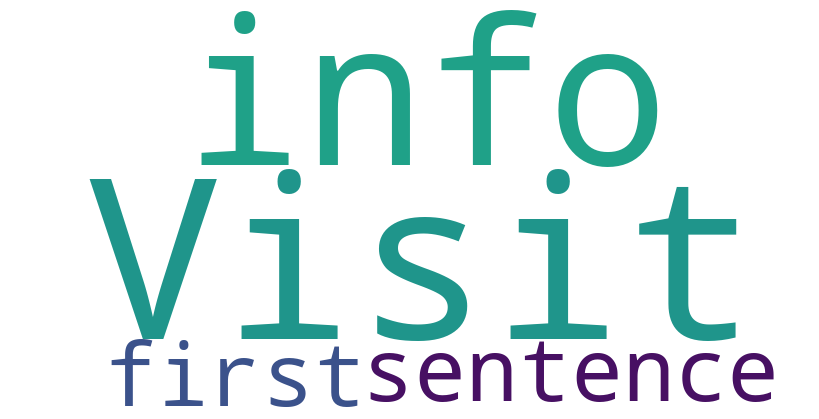

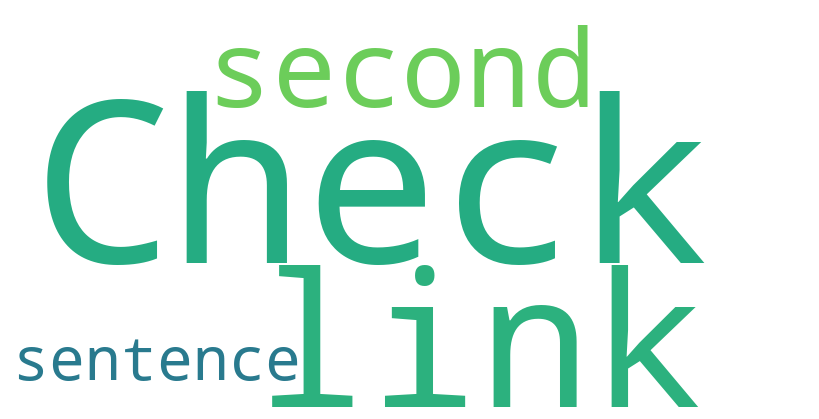

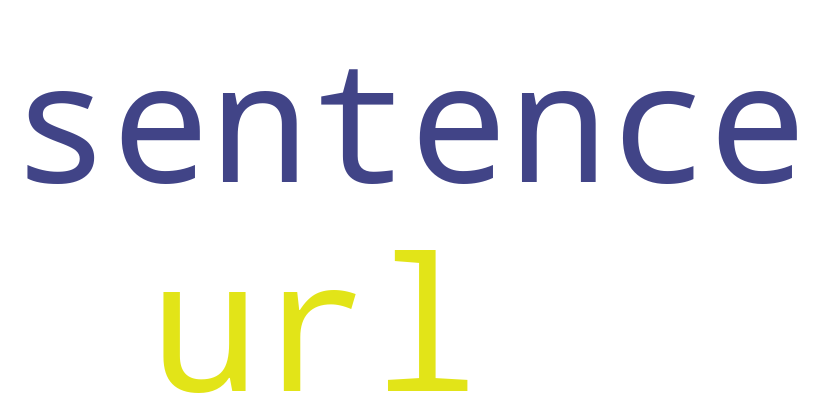

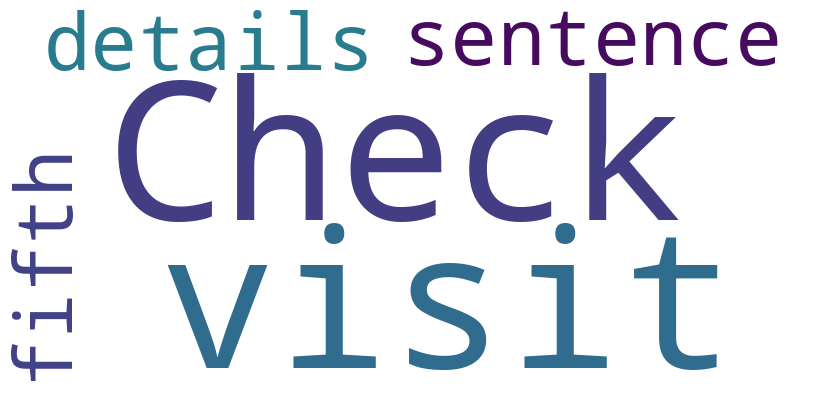

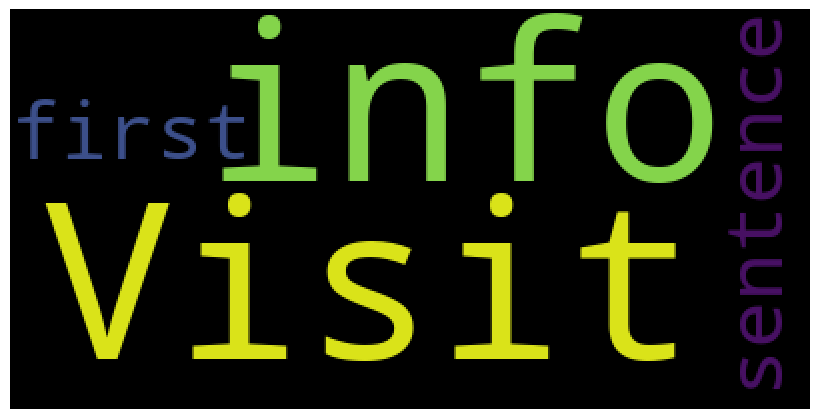

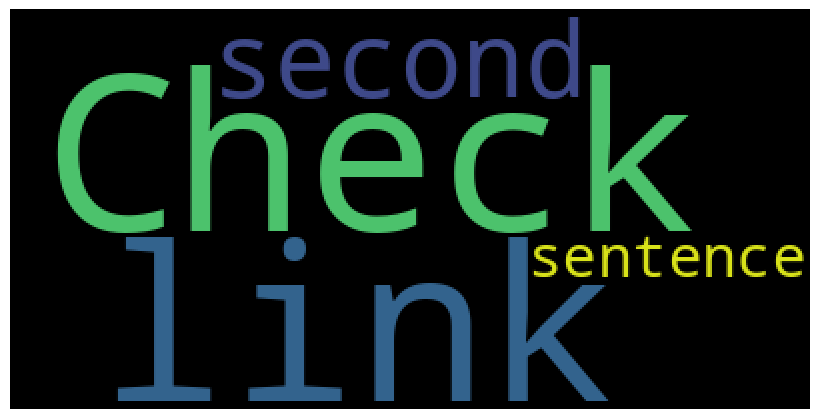

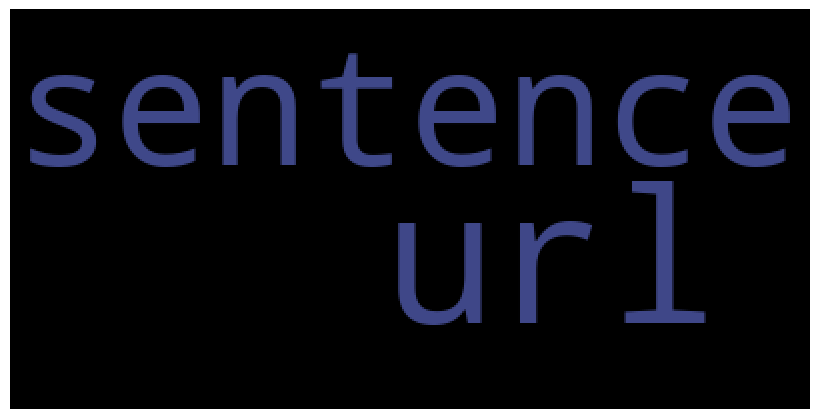

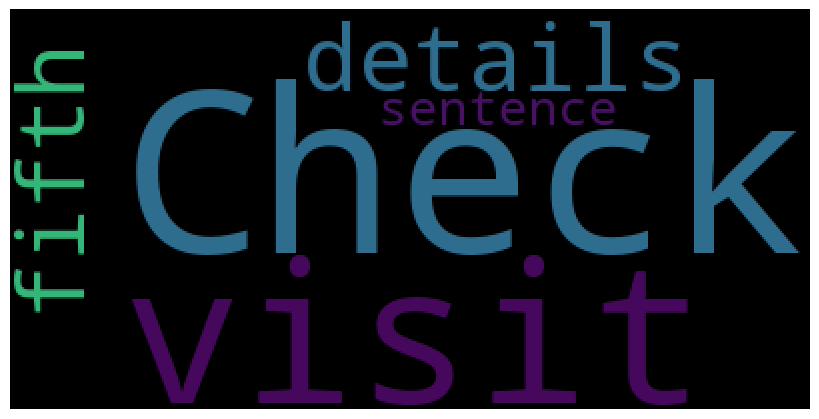

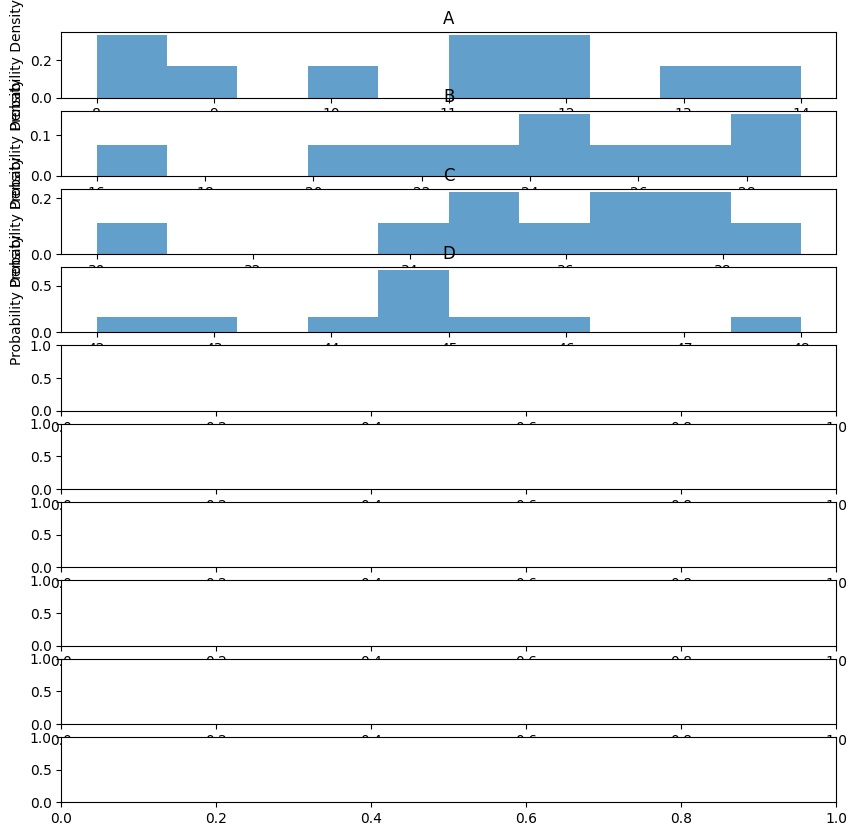

EEEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 18, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 29, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 46, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
-------------------------------------------------

   z_score_A  z_score_B  z_score_C  z_score_D
0         10         20         30  44.666667
1         12         22         34  42.000000
2         14         16         35  44.000000
3          8         28         36  44.666667
4          9         27         37  46.000000
5         11         23         38  45.000000
6         13         25         39  43.000000
7          8         29         38  44.666667
8         11         24         37  48.000000
9         12         26         35  44.666667
Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            {
                "col1": [1, 7, 3],
                "col2": [4, 5, 7],
                "col3": [None, None, None],
            }
        )
        zscores, plots = task_func(df)
        self.assertAlmostEqual(zscores.mean().mean(), 0

EEEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 18, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 29, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 46, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
-------------------------------------------------

Generated Code
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

def task_func(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    z_scores = df[numeric_cols].apply(zscore)
    plt.figure(figsize=(10, 6))
    plots = [z_scores.plot(kind='hist', bins=10, alpha=0.5, title=col_name) for col_name in numeric_cols]
    return z_scores, plots


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
import numpy as np
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            {
                "col1": [1, 7, 3],
                "col2": [4, 5, 7],
                "col3": [None, None, None],
            }
        )
        zscores, plots = task_func(df)
        self.assertAlmostEqual(zscores.mean().mean(), 0.0, places=6)
        self.ass

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in test_case_1
NameError: name 'pd' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 24, in test_case_2
NameError: name 'pd' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 31, in test_case_3
NameError: name 'pd' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 38, in test_case_4
NameError: name 'pd' is not defined

ERROR: test_case_5 (builtins.TestCases)
---------------------------------------------------

Generated Code
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def task_func(df):
    # Standardize numeric columns
    scaler = StandardScaler()
    df_std = df.copy()

    # Replace missing values with the column's average
    df_std.fillna(df_std.mean(), inplace=True)

    # Standardize columns
    df_std[df_std.select_dtypes(include='numeric').columns] = scaler.fit_transform(df_std[df_std.select_dtypes(include='numeric')])

    # Create correlation matrix
    corr_matrix = df_std.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

    return df_std


Prompt
The generated code fails the following tests:

import unittest
import pandas as pd
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def test_case_1(self):
        df = pd.DataFrame(
            [[1, 2, 3], [4, 5, 6], [7, None, 9]], columns=["c1", "c2", "c3"]
        )

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceba

Generated Code
import time
from datetime import datetime
import random
import matplotlib.pyplot as plt
# Constants
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
def task_func(n, output_path=None):
    # Generate n random Unix timestamps
    timestamps = [int(time.time()) for _ in range(n)]

    # Convert the timestamps to strings formatted as UTC DATE_FORMAT
    formatted_timestamps = [datetime.utcfromtimestamp(t).strftime(DATE_FORMAT) for t in timestamps]

    # Plot a histogram of the distribution of the generated timestamps
    plt.hist(timestamps, bins=range(min(timestamps), max(timestamps)+60, 60))
    plt.xlabel('Unix Timestamp')
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + str(n) + ' Random Unix Timestamps')

    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()

    # Return the list of formatted timestamps
    return formatted_timestamps


Prompt
The generated code fails the following tests:

import unittest
import os
class TestCases(unittest.Tes

EEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceba

Generated Code
import time
from datetime import datetime
import random
import matplotlib.pyplot as plt
# Constants
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
def task_func(n, output_path=None):
    # Generate n random Unix timestamps and convert them to strings formatted as UTC DATE_FORMAT
    timestamps = [datetime.utcfromtimestamp(random.randint(0, int(time.time()))).strftime(DATE_FORMAT) for _ in range(n)]

    # Plot a histogram of the distribution of the generated timestamps
    plt.hist(timestamps, bins='auto')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Save the histogram to the specified path if provided
    if output_path:
        plt.savefig(output_path)

    # Display the plot if no output path is provided
    plt.show()

    # Return the list of formatted timestamps
    return timestamps


Prompt
The generated code fails the following tests:

import unittest
import os
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def setUp(sel

EE.EE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_1
  File "<string>", line 50, in assert_function_output
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 17, in test_case_2
  File "<string>", line 50, in assert_function_output
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 28, in test_case_4
  File "<string>", line 50, in assert_function_output
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (mo

Generated Code
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Constants
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
def task_func(timestamps):
    if not timestamps:
        raise ValueError("Input list of timestamps is empty.")

    # Convert the list of Unix timestamps to datetime objects
    datetime_list = [datetime.utcfromtimestamp(ts) for ts in timestamps]

    # Create a DataFrame
    df = pd.DataFrame({
        "Timestamp": timestamps,
        "Datetime": [d.strftime(DATE_FORMAT) for d in datetime_list]
    })

    # Draw a histogram
    df["Datetime"].hist(bins=10)
    plt.title("Distribution of Datetimes")
    plt.xlabel("Date and Time")
    plt.ylabel("Frequency")
    return df, plt.gca()


Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def setUp(self):
        self.test_data = [
            [1318935276, 1342905276, 23074268],
          

EE.EE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_case_1
  File "<string>", line 46, in assert_function_output
  File "<string>", line 16, in task_func
  File "/usr/local/lib/python3.10/dist-packages/pandas/plotting/_core.py", line 1031, in __call__
    return plot_backend.plot(data, kind=kind, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/__init__.py", line 71, in plot
    plot_obj.generate()
  File "/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py", line 450, in generate
    self._args_adjust()
  File "/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/hist.py", line 76, in _args_adjust
    self.bins = self._calculate_bins(self.data)
  File "/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/hist.py", line 87, in _calculate_bins
    hist, bins = np.

Generated Code
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
# Constants
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
def task_func(timestamps):
    if not timestamps:
        raise ValueError("Input list of timestamps is empty.")

    df = pd.DataFrame({
        "Timestamp": timestamps,
        "Datetime": [datetime.fromtimestamp(timestamp) for timestamp in timestamps]
    })

    fig, ax = plt.subplots(figsize=(10, 5))
    df["Datetime"].plot(kind="hist", ax=ax)

    return df, ax


Prompt
The generated code fails the following tests:

import unittest
class TestCases(unittest.TestCase):
    """Test cases for the task_func function."""
    def setUp(self):
        self.test_data = [
            [1318935276, 1342905276, 23074268],
            [4235087541, 1234653346, 19862358],
            [],
            [1156829289],
            [1000000000, 2000000000, 3000000000],
        ]
    def test_case_1(self):
        input_timestamps = self.test_data[0]
        self

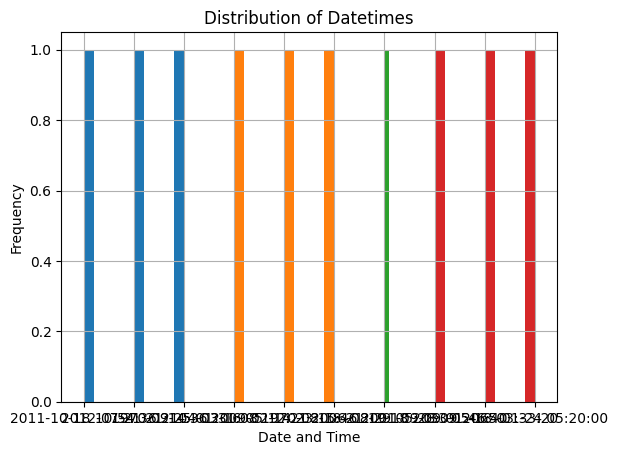

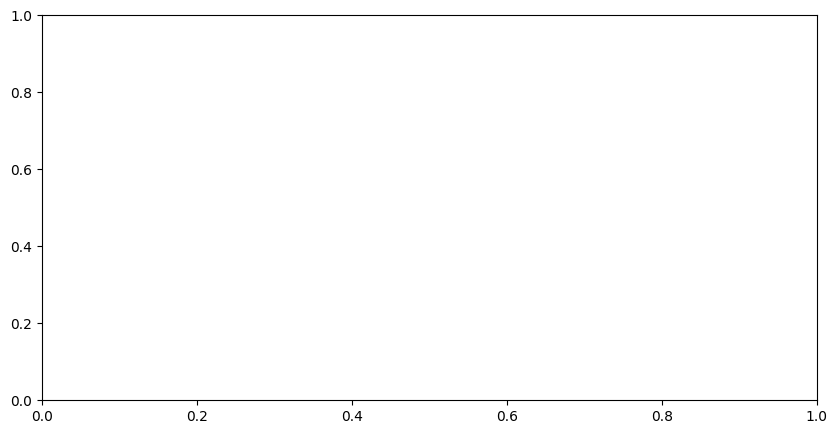

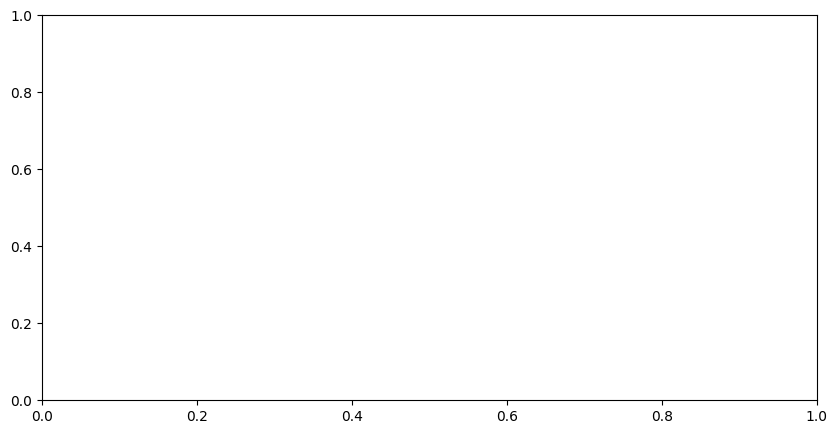

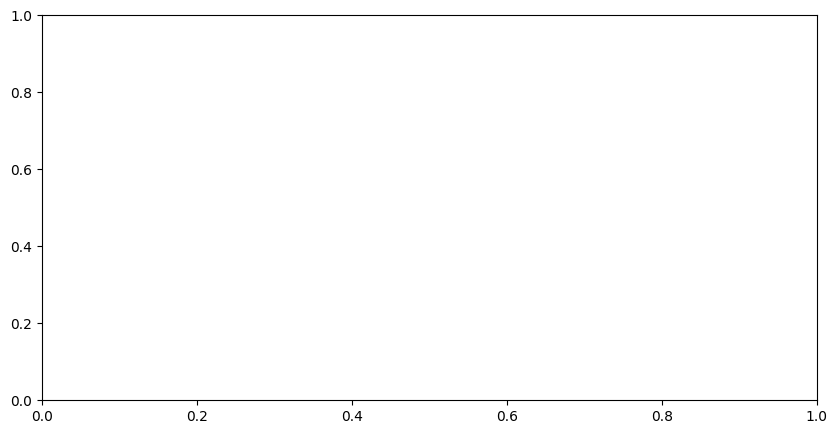

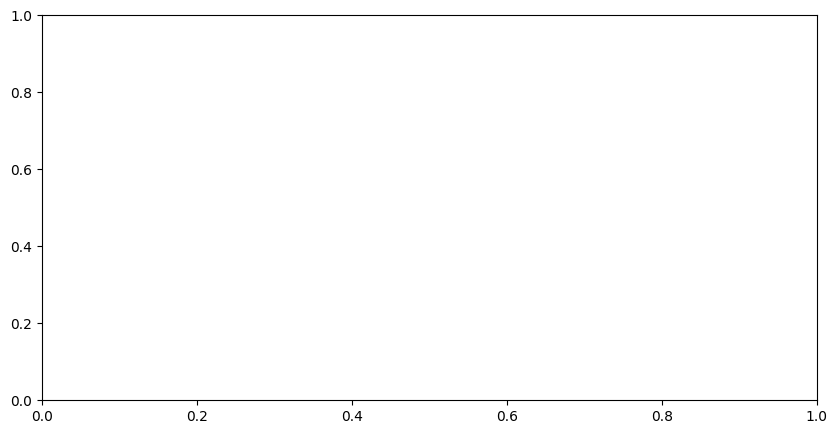

In [30]:
generated_scores_last20 = {name: [] for name in model_names}
i = 0
for example in dataset:
    i+=1
    if i < 32:
      continue
    print(i)
    prompt = example["instruct_prompt"]
    # print("Prompt:" + prompt)
    # print("Output:")
    for model_name in model_names:
        generated_score = generate_score(prompt, models[model_name], tokenizers[model_name], example)
        generated_scores_last20[model_name].append(generated_score)

## ***Evaluation***

In [ ]:
# # Evaluation Setup with BLEU (or CodeBLEU if available)
# bleu_metric = evaluate.load("bleu")

# # Prepare reference code for evaluation
# references = [example["canonical_solution"] for example in dataset]

# # Evaluate each model's generated code against the reference code
# evaluation_scores = {}
# for model_name, codes in generated_codes.items():
#     bleu_score = bleu_metric.compute(predictions=codes, references=references)
#     evaluation_scores[model_name] = bleu_score["bleu"]
#     print(f"{model_name} BLEU Score:", bleu_score["bleu"])

# # Print final evaluation summary
# print("\n=== Evaluation Summary ===")
# for model_name, score in evaluation_scores.items():
#     print(f"{model_name} BLEU Score: {score:.4f}")

In [12]:
import unittest
from unittest.mock import patch

def evaluate_code_generation(generated_code, test_cases_code, libraries):
    """
    Dynamically evaluates the generated code based on pass ratio and executability.

    Parameters:
    - generated_code: A string containing the code to be evaluated.
    - test_cases_code: A string containing the test cases to be executed.
    - libraries: A list of library names to import and make available in the execution context.

    Returns:
    - A dictionary containing 'pass_ratio', 'executability', and 'errors'.
    """



    # Prepare a local namespace for executing the generated code
    local_namespace = {}
    error_messages = []

    # Import libraries dynamically and add them to the namespace
    for lib in libraries:
        try:
            # Import each library and add it to the local namespace
            local_namespace[lib] = __import__(lib)
        except ImportError as e:
            error_messages.append(f"Error importing {lib}: {e}")
            return {
                'pass_ratio': 0,
                'executability': False,
                'errors': error_messages
            }

    try:
        # Execute the generated code in the provided namespace
        exec(generated_code, local_namespace, local_namespace)
        executability = True
    except Exception as e:
        error_messages.append(f"Execution Error: {e}")
        executability = False

    if not executability:
        return {
            'pass_ratio': 0,
            'executability': executability,
            'errors': error_messages
        }

    # Add task_func to local_namespace so it can be accessed by tests
    task_func = local_namespace.get('task_func')

    if not task_func:
        error_messages.append("task_func is not defined in the generated code.")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Dynamically create a TestCase class from the provided test cases code
    try:
        exec(test_cases_code, {'task_func': task_func, 'patch': patch}, local_namespace)
    except Exception as e:
        error_messages.append(f"Test case execution error: {e}")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Extract the TestCase class from the local namespace
    TestClass = local_namespace.get('TestCases')

    if not TestClass:
        error_messages.append("TestCases class not found in provided test cases code.")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Define a custom test suite
    class CustomTestSuite(unittest.TestSuite):
        def run(self, result, debug=False):
            super().run(result, debug)
            return result

    # Run the tests using unittest framework
    suite = CustomTestSuite()
    suite.addTest(unittest.makeSuite(TestClass))

    runner = unittest.TextTestRunner()

    # Capture results
    result = runner.run(suite)

    # Calculate pass ratio
    pass_ratio = (result.testsRun - len(result.failures) - len(result.errors)) / result.testsRun if result.testsRun > 0 else 0

    # Collect errors from test results
    for failure in result.failures + result.errors:
        error_messages.append(str(failure))

    # Clear the local namespace after execution
    local_namespace.clear()

    return {
        'pass_ratio': pass_ratio,
        'executability': len(result.errors) == 0,
        'errors': error_messages
    }

In [ ]:
# Example usage with dynamic inputs and libraries list
generated_code = """
import itertools
from random import shuffle

def task_func(numbers=list(range(1, 11))):
    permutations = list(itertools.permutations(numbers))
    sum_diffs = 0

    for perm in permutations:
        perm = list(perm)
        shuffle(perm)
        diffs = [abs(perm[i] - perm[i+1]) for i in range(len(perm)-1)]
        sum_diffs += sum(diffs)

    avg_sum_diffs = sum_diffs / len(permutations) if permutations else 0

    return avg_sum_diffs
"""

test_cases_code = """
import unittest

class TestCases(unittest.TestCase):

    def test_default_numbers(self):
        result = task_func()
        self.assertIsInstance(result, float)
        self.assertGreater(result, 0)

# Additional tests omitted for brevity...
"""

# List of libraries to import and use within exec()
libraries_to_import = []

# Evaluate the generated code with dynamic inputs and specified libraries
evaluation_result = evaluate_code_generation(generated_code, test_cases_code, libraries_to_import)
print(evaluation_result)

.
----------------------------------------------------------------------
Ran 1 test in 20.591s

OK


{'pass_ratio': 1.0, 'executability': True, 'errors': []}


In [ ]:
#TODO : Implement a function to average teh scores from each list in generate_score which is sthe final score of the model

In [ ]:
average = sum(generated_scores['Mistral-7B']) / len(generated_scores['Mistral-7B'])

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

In [ ]:
average

NameError: name 'average' is not defined

In [15]:
len(generated_scores['Mistral-7B'])

31

In [32]:
len(generated_scores_last20['Mistral-7B'])

19

In [34]:
# prompt: write a code to merge generated_scores and generated scores_last20 into a new dict

merged_scores = {}
for model_name in model_names:
    merged_scores[model_name] = generated_scores_last20[model_name]
    # Assuming 'generated_scores' exists and has the same structure
    if model_name in generated_scores:
      merged_scores[model_name].extend(generated_scores[model_name])

In [36]:
len(merged_scores["Mistral-7B"])

50

In [37]:
# prompt: write a code to iterate over each part of merged scores ["mistral-7b"
# and average the pass ratio

# Calculate the average pass ratio for each model in merged_scores
average_pass_ratios = {}
for model_name, scores in merged_scores.items():
  total_pass_ratio = 0
  for score_dict in scores:
    total_pass_ratio += score_dict.get("pass_ratio", 0)  # Handle potential missing keys
  average_pass_ratios[model_name] = total_pass_ratio / len(scores) if scores else 0

# Print the average pass ratios
for model_name, avg_ratio in average_pass_ratios.items():
  print(f"Average pass ratio for {model_name}: {avg_ratio}")

Average pass ratio for Mistral-7B: 0.06266666666666666


In [38]:
merged_scores

{'Mistral-7B': [{'pass_ratio': 0.0,
   'executability': False,
   'errors': ['(<builtins.TestCases testMethod=test_case_1>, \'Traceback (most recent call last):\\n  File "<string>", line 25, in test_case_1\\n  File "<string>", line 111, in task_func\\n  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 129, in word_tokenize\\n    sentences = [text] if preserve_line else sent_tokenize(text, language)\\n  File "/usr/local/lib/python3.10/dist-packages/nltk/tokenize/__init__.py", line 106, in sent_tokenize\\n    tokenizer = load(f"tokenizers/punkt/{language}.pickle")\\n  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 750, in load\\n    opened_resource = _open(resource_url)\\n  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 876, in _open\\n    return find(path_, path + [""]).open()\\n  File "/usr/local/lib/python3.10/dist-packages/nltk/data.py", line 583, in find\\n    raise LookupError(resource_not_found)\\nLookupError: \\n